# Lab 5: Object recognition with convolutional neural networks
In this lab we consider the [CIFAR dataset](https://www.openml.org/d/40926), but model it using convolutional neural networks instead of linear models.
There is no separate tutorial, but you can find lots of examples in the lecture notebook on convolutional neural networks.

Tip: You can run these exercises faster on a GPU (but they will also run fine on a CPU). If you do not have a GPU locally, you can upload this notebook to Google Colab. You can enable GPU support at “runtime” -> “change runtime type”.

In [3]:
# !pip install torch openml matplotlib

In [138]:
from random import randint
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import openml as oml
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from tqdm import tqdm
%matplotlib inline

In [139]:
# Download CIFAR data. Takes a while the first time.
# This version returns 3x32x32 resolution images. 
# If you feel like it, repeat the exercises with the 96x96x3 resolution version by using ID 41103 
cifar = oml.datasets.get_dataset(40926) 
X, y, _, _ = cifar.get_data(target=cifar.default_target_attribute, dataset_format='array'); 
cifar_classes = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
                 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_95614/3346526928.py:5: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = cifar.get_data(target=cifar.default_target_attribute, dataset_format='array');


In [140]:
# The data is in a weird 3x32x32 format, we need to reshape and transpose
Xr = X.reshape((len(X),3,32,32)).transpose(0,2,3,1)

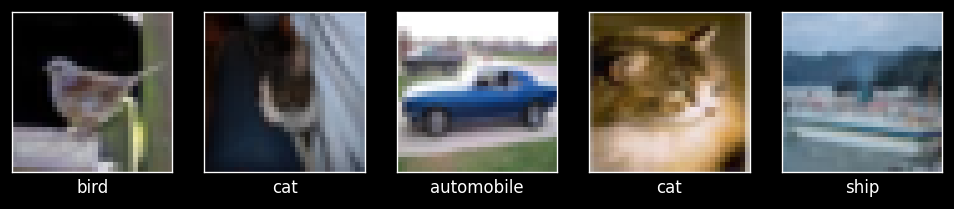

In [141]:
# Take some random examples, reshape to a 32x32 image and plot

fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,len(Xr))
    # The data is stored in a 3x32x32 format, so we need to transpose it
    axes[i].imshow(Xr[n]/255)
    axes[i].set_xlabel((cifar_classes[int(y[n])]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

## Define training functions

In [ ]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

# def fit(model, criterion, optimizer, num_epochs, train_loader, test_loader):
def fit(model: torch.nn.Module, criterion: nn.Module, optimizer: optim.Optimizer,
        num_epochs: int, train_loader: DataLoader, test_loader: DataLoader) -> dict:
    """
    Train a PyTorch model.
    """
    device = get_device()
    model.to(device)

    bar = tqdm(range(num_epochs), desc="Training", unit="epoch")

    history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}
    for epoch in bar:
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        history["loss"].append(train_loss)
        history["accuracy"].append(train_acc)

    # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)

        val_loss /= len(test_loader)
        val_acc = correct / total
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
        bar.set_postfix(epoch=epoch+1/num_epochs, loss=train_loss, val_loss=val_loss, accuracy=train_acc, val_accuracy=val_acc)
    return history

def plot_results(history):
    df = pd.DataFrame(history)
# Plot the training history
    df[['accuracy', 'val_accuracy', 'loss', 'val_loss']].plot(lw=2, style=['b:', 'r:', 'b-', 'r-'])
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.title("Training & Validation Metrics")
    plt.show()

# Print max validation accuracy
    print("Max val_acc:", np.max(history["val_accuracy"]))

## Exercise 1: A simple model
* Split the data into 80% training and 20% validation sets
* Normalize the data to [0,1]
* Build a ConvNet with 3 convolutional layers interspersed with MaxPooling layers, and one dense layer.
    * Use at least 32 filters in the first layer and ReLU activation.
    * Otherwise, make rational design choices or experiment a bit to see what works.
* You should at least get 60% accuracy.
* For training, you can try batch sizes of 64, and 20-50 epochs, but feel free to explore this as well
* Plot and interpret the learning curves


In [7]:
X_train, X_test, y_train, y_test = train_test_split(Xr,y, stratify=y, train_size=0.8)

In [8]:
# Normalize the input data
X_train = torch.from_numpy(X_train).float() / 255.0
X_test = torch.from_numpy(X_test).float() / 255.0


# Convert labels to one-hot encoding
num_classes = y_train.max() + 1  # Get the number of classes dynamically

y_train = F.one_hot(torch.from_numpy(y_train).long(), num_classes=num_classes).float()
y_test = F.one_hot(torch.from_numpy(y_test).long(), num_classes=num_classes).float()


# Ensure correct shape
y_train = y_train.to(torch.float32)
y_test = y_test.to(torch.float32)

In [9]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Change (N, H, W, C) -> (N, C, H, W)
y_train_tensor = torch.tensor(y_train.argmax(axis=1), dtype=torch.long)  # Convert one-hot to class indices
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test.argmax(axis=1), dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_95614/65299650.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Change (N, H, W, C) -> (N, C, H, W)
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_95614/65299650.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train.argmax(axis=1), dtype=torch.long)  # Convert one-hot to class indices
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_95614/65299650.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().req

In [10]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 64)  # Adjusted for CIFAR-10 image size
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)  # Flatten before FC layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No softmax, as CrossEntropyLoss includes it
        return x

/Users/smukherjee/.pyenv/versions/openmlpytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training: 100%|██████████| 25/25 [00:30<00:00,  1.24s/epoch, accuracy=0.975, epoch=24, loss=0.0816, val_accuracy=0.631, val_loss=2.02]


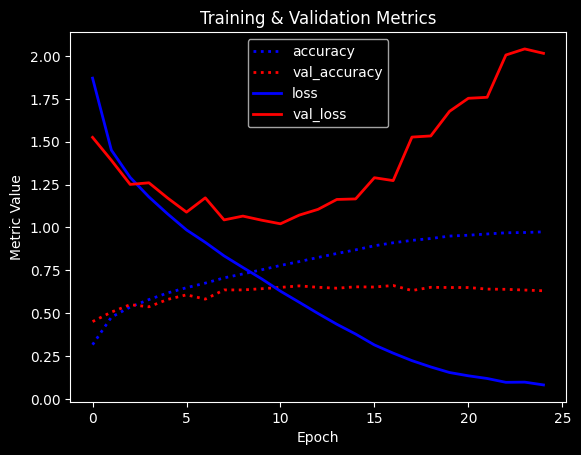

Max val_acc: 0.6615


In [11]:
# Initialize model, loss function, and optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

history = fit(
    model= model,
    criterion= criterion,
    optimizer= optimizer,
    num_epochs= 25,
    train_loader= train_loader,
    test_loader= test_loader
)


plot_results(history)

Already decent performance but the model starts overfitting heavily.

## Exercise 2: VGG-like model
* Mimic the VGG model by building 3 'blocks' of 2 convolutional layers each
* Do MaxPooling after each block
* The first layer should have at least 32 filters
* Use zero-padding to be able to build a deeper model
* Use a dense layer with at least 128 hidden nodes.
* Plot and interpret the learning curves


In [12]:
class CNNModel2(nn.Module):
    def __init__(self):
        super(CNNModel2, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Same padding
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjusted for 32x32 input size
        self.fc2 = nn.Linear(128, 10)  # 10 output classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)

        x = torch.flatten(x, start_dim=1)  # Flatten for FC layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No softmax since CrossEntropyLoss includes it
        return x


Training: 100%|██████████| 25/25 [00:55<00:00,  2.21s/epoch, accuracy=0.967, epoch=24, loss=0.0971, val_accuracy=0.632, val_loss=2.37]


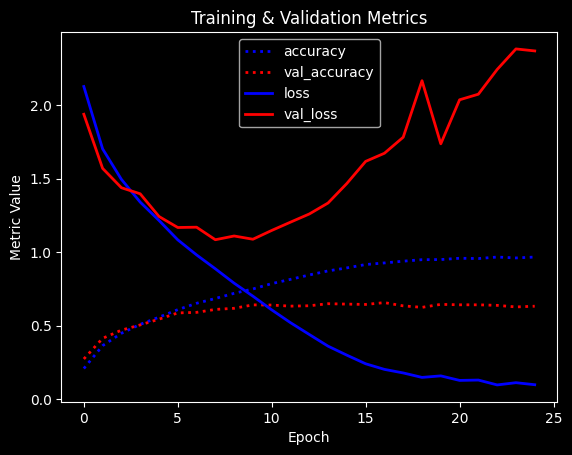

Max val_acc: 0.6565


In [13]:
# Initialize model, loss function, and optimizer
model = CNNModel2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

history = fit(
    model= model,
    criterion= criterion,
    optimizer= optimizer,
    num_epochs= 25,
    train_loader= train_loader,
    test_loader= test_loader
)


plot_results(history)

Better result, but still overfitting heavily

## Exercise 3: Regularization
* Explore different ways to regularize your VGG-like model
  * Try adding some dropout after every MaxPooling and Dense layer.
    * What are good Dropout rates?
  * Try batch nornmalization together with Dropout
* Plot and interpret the learning curves


In [14]:
class CNNModel3(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel3, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjusted for CIFAR-10 image size (32x32)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)  # Equivalent to softmax but more numerically stable in PyTorch


Training: 100%|██████████| 25/25 [00:56<00:00,  2.27s/epoch, accuracy=0.834, epoch=24, loss=0.459, val_accuracy=0.694, val_loss=1.05] 


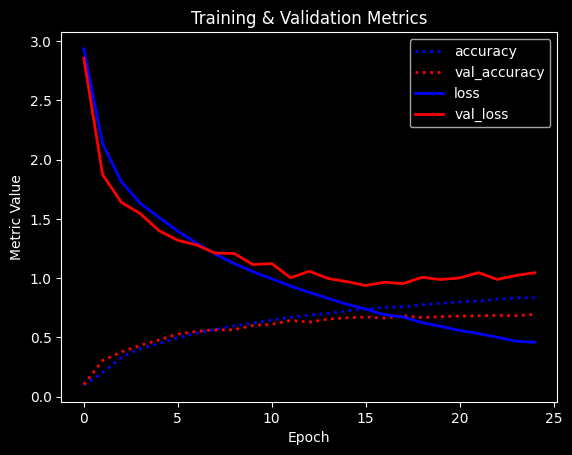

Max val_acc: 0.694


In [15]:
# Initialize model, loss function, and optimizer
model = CNNModel3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

history = fit(
    model= model,
    criterion= criterion,
    optimizer= optimizer,
    num_epochs= 25,
    train_loader= train_loader,
    test_loader= test_loader
)


plot_results(history)

Accuracy is quite a bit better and overfitting seems lessened

Another common approach is to gradually increase the amount of dropout. This forces layers deep in the model to regularize more than layers closer to the input.

In [16]:
class CNNModel4(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel4, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjusted for CIFAR-10 image size (32x32)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # First Block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)

        # Second Block
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout2(x)

        # Third Block
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout3(x)

        # Flatten
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)  # Softmax for multi-class classification


Training: 100%|██████████| 25/25 [00:58<00:00,  2.33s/epoch, accuracy=0.743, epoch=24, loss=0.73, val_accuracy=0.713, val_loss=0.863] 


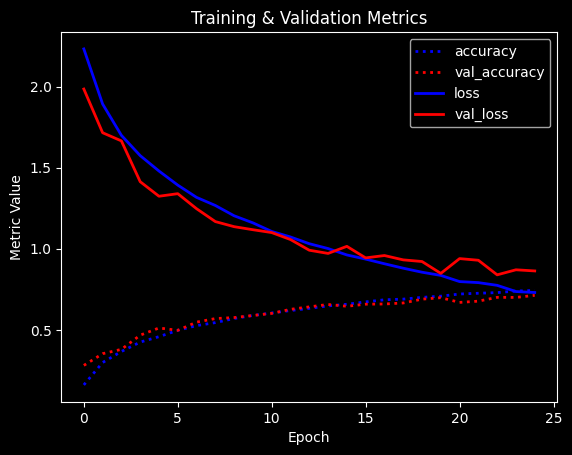

Max val_acc: 0.7125


In [17]:
# Initialize model, loss function, and optimizer
model = CNNModel4()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

history = fit(
    model= model,
    criterion= criterion,
    optimizer= optimizer,
    num_epochs= 25,
    train_loader= train_loader,
    test_loader= test_loader
)


plot_results(history)

Slightly better accuracy and very little overfitting remains.

Next, we try adding Batch Normalization.

In [18]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate):
        super(CNNBlock, self).__init__()
        
        # Define the block: Conv -> BatchNorm -> ReLU -> Dropout
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        return x

class CNNModel5(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel5, self).__init__()
        
        # Define the layers using CNNBlock for modularity
        self.block1 = CNNBlock(in_channels=3, out_channels=32, dropout_rate=0.2)
        self.block2 = CNNBlock(in_channels=32, out_channels=64, dropout_rate=0.3)
        self.block3 = CNNBlock(in_channels=64, out_channels=128, dropout_rate=0.4)

        # Fully Connected Layer: Dense -> BatchNorm -> Dropout -> Dense (Softmax)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjusted for CIFAR-10 image size (32x32)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Pass through all the blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        # Flatten and Fully Connected
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)  # Equivalent to softmax but more numerically stable in PyTorch


Training: 100%|██████████| 25/25 [01:15<00:00,  3.03s/epoch, accuracy=0.862, epoch=24, loss=0.398, val_accuracy=0.794, val_loss=0.634]  


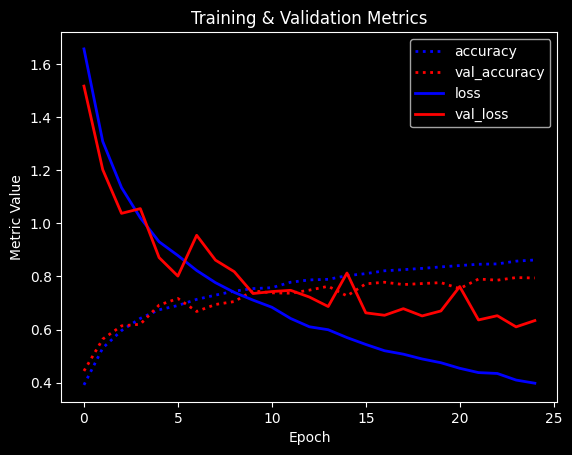

Max val_acc: 0.7955


In [19]:
# Initialize model, loss function, and optimizer
model = CNNModel5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

history = fit(
    model= model,
    criterion= criterion,
    optimizer= optimizer,
    num_epochs= 25,
    train_loader= train_loader,
    test_loader= test_loader
)


plot_results(history)

## Exercise 4: Data Augmentation
* Perform image augmentation. You can use the ImageDataGenerator for this.
* What is the effect? What is the effect with and without Dropout?
* Plot and interpret the learning curves


In [143]:
class AugmentedDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        
        # Apply the transform if it is provided
        if self.transform:
            image = torchvision.transforms.functional.to_pil_image(image)  # Convert the tensor to a PIL image
            image = self.transform(image)
        
        return image, label

# Define data augmentation and normalization transforms for training
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define transform for testing (no augmentation, just normalization)
test_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])


In [144]:
X_train, X_test, y_train, y_test = train_test_split(Xr,y, stratify=y, train_size=0.8)
# Normalize the input data
X_train = torch.from_numpy(X_train).float() / 255.0
X_test = torch.from_numpy(X_test).float() / 255.0


# Convert labels to one-hot encoding
num_classes = y_train.max() + 1  # Get the number of classes dynamically

y_train = F.one_hot(torch.from_numpy(y_train).long(), num_classes=num_classes).float()
y_test = F.one_hot(torch.from_numpy(y_test).long(), num_classes=num_classes).float()


# Ensure correct shape
y_train = y_train.to(torch.float32)
y_test = y_test.to(torch.float32)
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Change (N, H, W, C) -> (N, C, H, W)
y_train_tensor = torch.tensor(y_train.argmax(axis=1), dtype=torch.long)  # Convert one-hot to class indices
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test.argmax(axis=1), dtype=torch.long)

# Create DataLoaders
train_dataset = AugmentedDataset(X_train_tensor, y_train_tensor, transform = train_transforms)
test_dataset = AugmentedDataset(X_test_tensor, y_test_tensor, transform = test_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_95614/2406529740.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Change (N, H, W, C) -> (N, C, H, W)
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_95614/2406529740.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train.argmax(axis=1), dtype=torch.long)  # Convert one-hot to class indices
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_95614/2406529740.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().det

In [145]:

# Define the CNNBlock
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate):
        super(CNNBlock, self).__init__()
        
        # Define the block: Conv -> BatchNorm -> ReLU -> Dropout
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        return x

# Define the CNNModel6 using CNNBlock
class CNNModel6(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel6, self).__init__()

        # First Block
        self.block1 = CNNBlock(in_channels=3, out_channels=32, dropout_rate=0.2)
        
        # Second Block
        self.block2 = CNNBlock(in_channels=32, out_channels=64, dropout_rate=0.3)
        
        # Third Block
        self.block3 = CNNBlock(in_channels=64, out_channels=128, dropout_rate=0.4)
        
        # Fully Connected Layer: Dense -> BatchNorm -> Dropout -> Dense (Softmax)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjusted for CIFAR-10 image size (32x32)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout layers for fully connected layers
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Pass through each CNNBlock
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        # Flatten and Fully Connected Layer
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)  # Equivalent to softmax but more numerically stable in PyTorch

Training: 100%|██████████| 25/25 [03:06<00:00,  7.44s/epoch, accuracy=0.791, epoch=24, loss=0.603, val_accuracy=0.822, val_loss=0.534]  


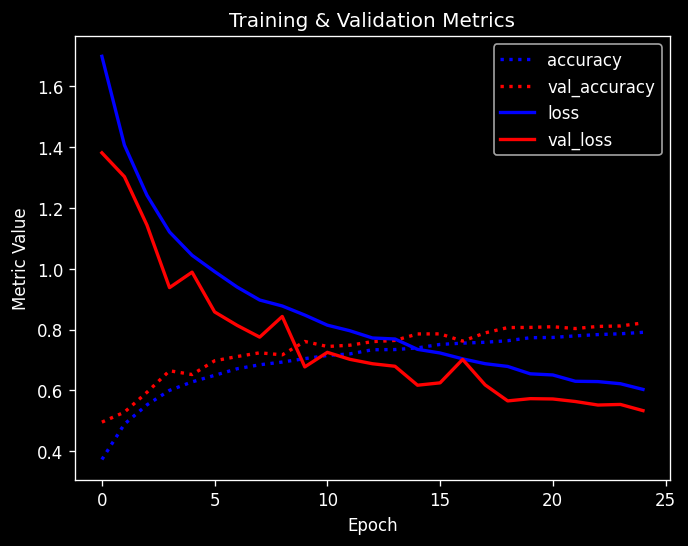

Max val_acc: 0.822


In [146]:
# Initialize model, loss function, and optimizer
model = CNNModel6()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

history = fit(
    model= model,
    criterion= criterion,
    optimizer= optimizer,
    num_epochs= 25,
    train_loader= train_loader,
    test_loader= test_loader
)


plot_results(history)

We get 2-3% improvement. We get the best results with very subtle data augmentation (small shifts and flips). The images are quite low resolution and rotation or sheer will destroy too much information.

## Exercise 5: Interpreting misclassifications
Chances are that even your best models are not yet perfect. It is important to understand what kind of errors it still makes.
* Run the test images through the network and detect all misclassified ones
* Interpret the results. Are these misclassifications to be expected? 
* Compute the confusion matrix. Which classes are often confused?

Since we have numeric outputs (a value per class), we need to take the class with the maximum value as the predicted class.

In [242]:
pred_device = torch.device("cpu")
model.to(pred_device)
y_pred = model(X_test_tensor.to(pred_device))

In [243]:
misclassified_samples = np.nonzero(np.not_equal(torch.argmax(y_test, axis=1), torch.argmax(y_pred, axis=1).cpu().numpy()))
misclassified_samples

tensor([[   0],
        [   5],
        [   6],
        ...,
        [3997],
        [3998],
        [3999]])

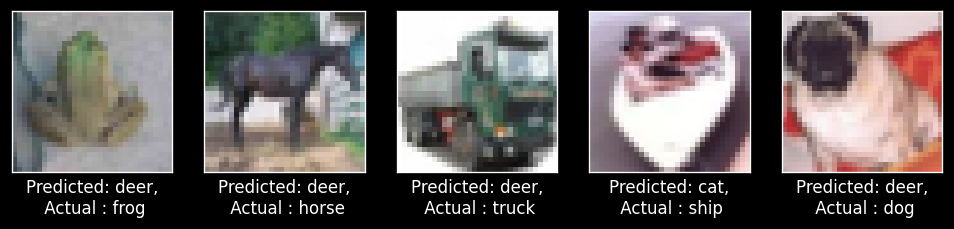

In [244]:
# Visualize the (first five) misclassifications, together with the predicted and actual class
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for nr, i in enumerate(misclassified_samples[:5]):
    axes[nr].imshow(X_test[i].reshape(32,32,3))
    axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (cifar_classes[int(torch.argmax(y_pred[i]))], cifar_classes[int(y_test[i].argmax())]))
    axes[nr].set_xticks(()), axes[nr].set_yticks(())

plt.show();

Some of these are indeed hard to categorize, although we can probably still improve the model quite a bit.

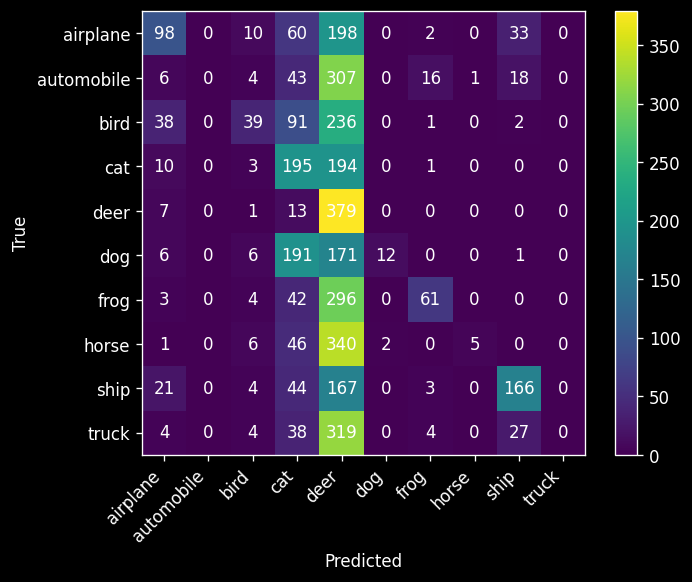

In [245]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), torch.argmax(y_pred, axis=1).cpu().numpy())
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_xticklabels(list(cifar_classes.values()), rotation=45, ha="right")
ax.set_yticklabels(list(cifar_classes.values()))
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

plt.colorbar(im)

Most misclassifications seem to involve cats, birds, and horses. The most common misclassification is between cats and dogs.

## Exercise 6: Interpreting the model
Retrain your best model on all the data. Next, retrieve and visualize the activations (feature maps) for every filter for every layer, or at least for a few filters for every layer. Tip: see the course notebooks for examples on how to do this. 

Interpret the results. Is your model indeed learning something useful?

In [246]:
model

CNNModel6(
  (block1): CNNBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (block2): CNNBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.3, inplace=False

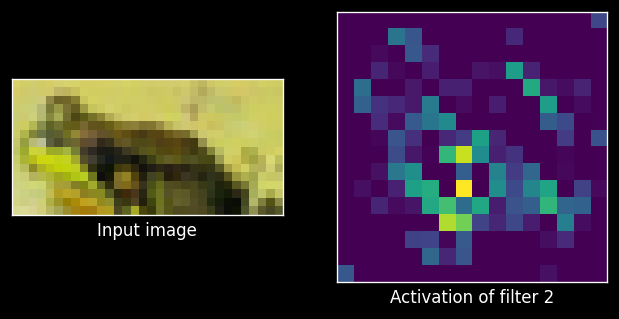

In [247]:

# Assuming `model` is a pre-trained PyTorch model
# `X_test` is your input tensor (in this case, an image)

img_tensor = X_test[4]  # Get the 5th image from the dataset
img_tensor = X_test[4].permute(2, 0, 1)
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension (batch_size = 1)
img_tensor = img_tensor.to(pred_device)  # Move to the same device as the model

# Define a hook function to capture activations
activations = []

def hook_fn(module, input, output):
    activations.append(output)

# Register hooks for the first 15 layers
hooks = []
for i, layer in enumerate(model.children()):
    if i < 15:
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

# Forward pass to get the activations
model.eval()
with torch.no_grad():
    _ = model(img_tensor)

# Now activations contains the output from the first 15 layers
# Plot the first layer activation
first_layer_activation = activations[0]

# Plotting the first activation map
plt.rcParams['figure.dpi'] = 120

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
img_tensor = img_tensor.cpu()  # Move to CPU for plotting
ax1.imshow(img_tensor[0].permute(1, 2, 0))  # Convert channels to last dimension for plotting
ax2.matshow(first_layer_activation[0, 2, :, :].cpu().numpy(), cmap='viridis')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Input image')
ax2.set_xlabel('Activation of filter 2')

images_per_row = 16

# Get the names of layers if necessary (optional)
# You can use model named children or inspect them manually

# Function to plot activations
def plot_activations(layer_index, activations):
    layer_activation = activations[layer_index]
    n_features = layer_activation.shape[1]  # Number of filters

    # Get the size of the feature map
    size = layer_activation.shape[2]

    # Create a grid for the feature maps
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, col * images_per_row + row, :, :].cpu().numpy()
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(f"Activation of layer {layer_index + 1}")
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()


/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_95614/131029784.py:67: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_95614/131029784.py:70: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


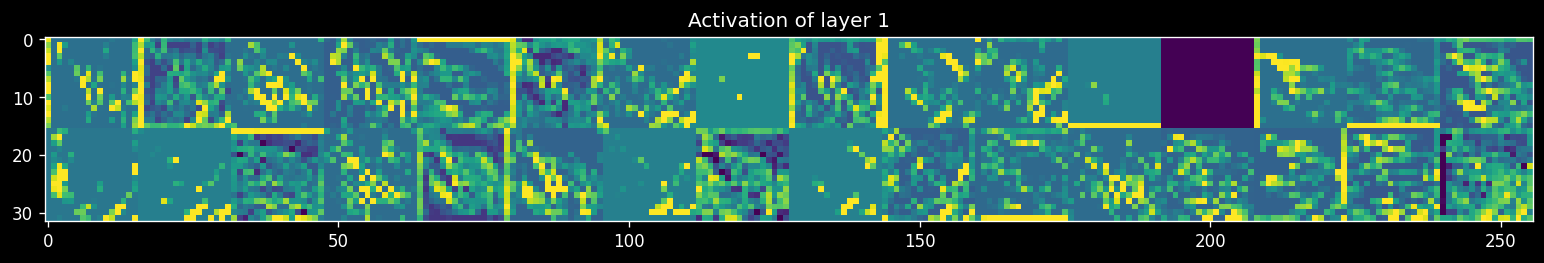

In [248]:
plot_activations(0, activations);

/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_95614/131029784.py:70: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


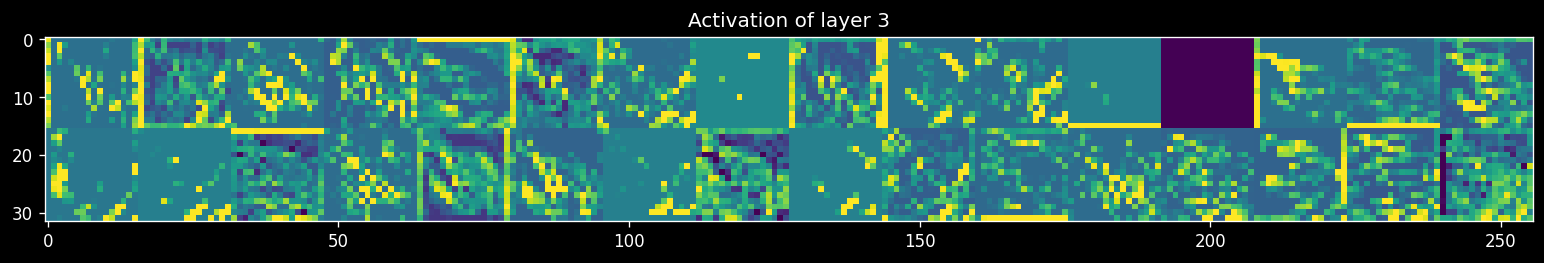

In [249]:
plot_activations(2, activations);

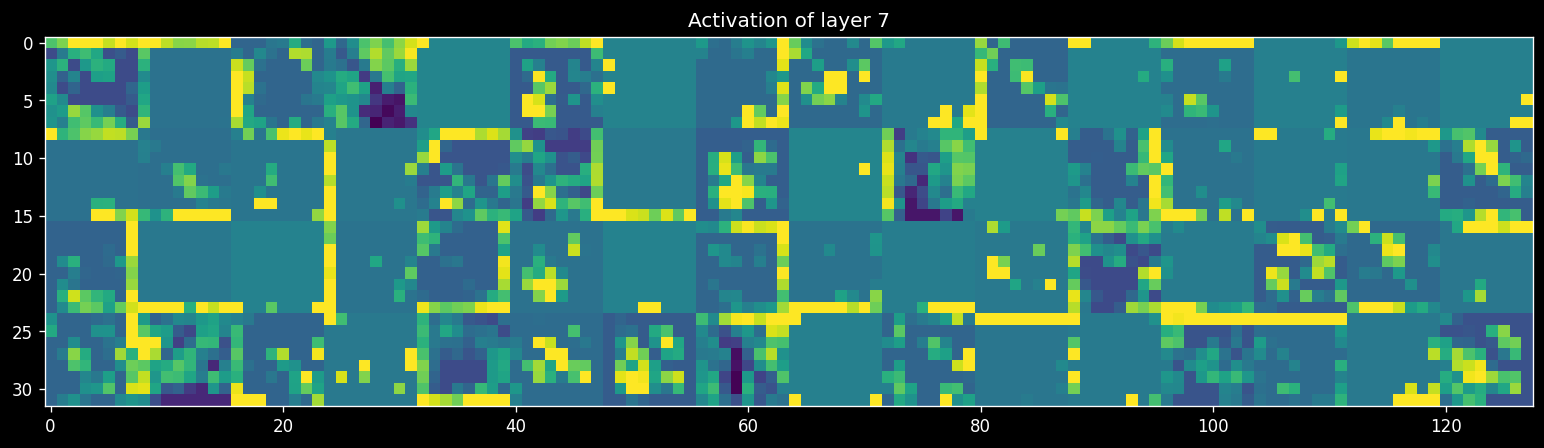

In [250]:
plot_activations(6, activations);

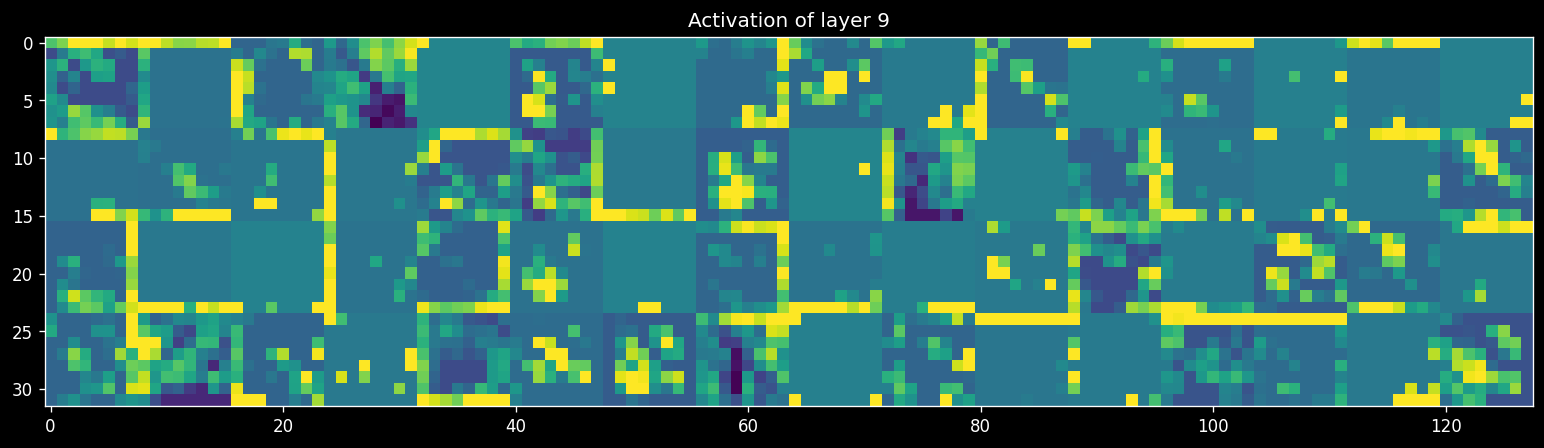

In [251]:
plot_activations(8, activations)

/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_95614/131029784.py:67: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_95614/131029784.py:70: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


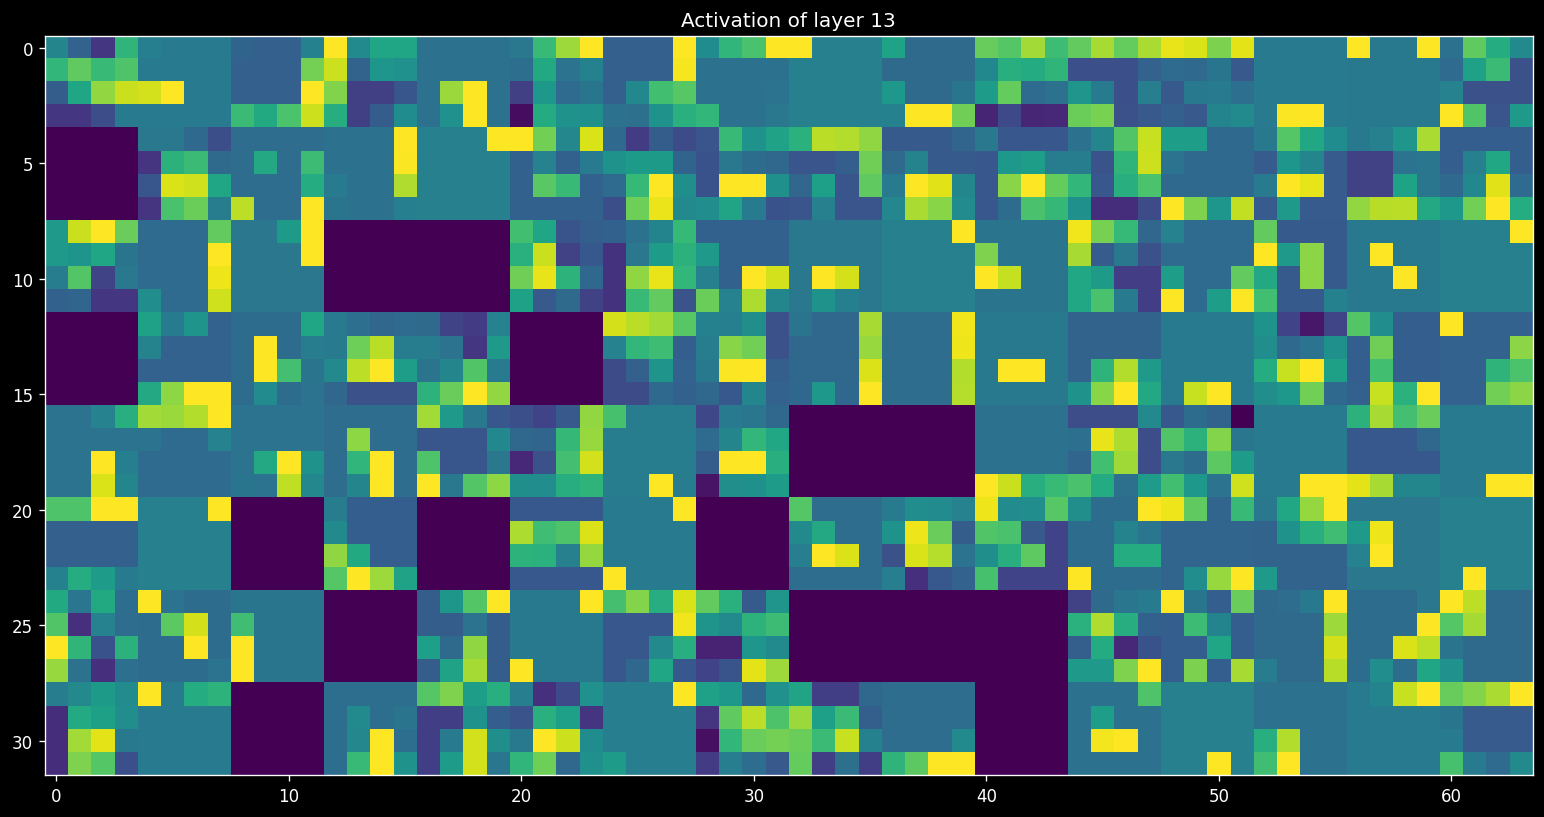

In [252]:
plot_activations(12, activations)

## Optional: Take it a step further
* Repeat the exercises, but now use a [higher-resolution version of the CIFAR dataset](https://www.openml.org/d/40926) (with OpenML ID 41103), or another [version with 100 classes](https://www.openml.org/d/41983) (with OpenML ID 41983). Good luck!
